<a href="https://colab.research.google.com/github/bheemeshpujari63/Rohlik-Orders-Forecasting-Challenge/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgbm
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
train = pd.read_csv('/content/drive/MyDrive/rohlik-orders-forecasting-challenge/train.csv')
test = pd.read_csv('/content/drive/MyDrive/rohlik-orders-forecasting-challenge/test.csv')
train_calendar = pd.read_csv('/content/drive/MyDrive/rohlik-orders-forecasting-challenge/train_calendar.csv')
test_calendar = pd.read_csv('/content/drive/MyDrive/rohlik-orders-forecasting-challenge/test_calendar.csv')

In [4]:
# Basic data exploration
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Train Calendar data shape: {train_calendar.shape}")
print(f"Test Calendar data shape: {test_calendar.shape}")

Training data shape: (7340, 18)
Test data shape: (397, 8)
Train Calendar data shape: (13307, 15)
Test Calendar data shape: (1869, 7)


In [5]:
train

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.80,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.50,0.0,1704.0,32410.0,Prague_1_2020-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,Budapest_1,2024-03-10,6733.0,NaN,0,0,0,0,0,0,0,0.0,0,1.51,0.0,2983.0,27111.0,Budapest_1_2024-03-10
7336,Budapest_1,2024-03-11,6492.0,NaN,0,0,0,0,0,0,0,0.0,0,1.03,0.0,2975.0,27133.0,Budapest_1_2024-03-11
7337,Budapest_1,2024-03-12,6661.0,NaN,0,0,0,0,0,0,0,0.0,0,0.21,0.0,2974.0,27151.0,Budapest_1_2024-03-12
7338,Budapest_1,2024-03-13,6843.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,2979.0,27180.0,Budapest_1_2024-03-13


In [6]:
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20
...,...,...,...,...,...,...,...,...
392,Budapest_1,2024-05-11,NaN,0,0,0,0,Budapest_1_2024-05-11
393,Budapest_1,2024-05-12,NaN,0,0,0,0,Budapest_1_2024-05-12
394,Budapest_1,2024-05-13,NaN,0,0,0,0,Budapest_1_2024-05-13
395,Budapest_1,2024-05-14,NaN,0,0,0,0,Budapest_1_2024-05-14


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 41104, number of used features: 29
[LightGBM] [Info] Start training from score 5739.739612
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 652180
✅ Validation MAPE: 0.1470
🎉 Submission file 'submission.csv' is ready!


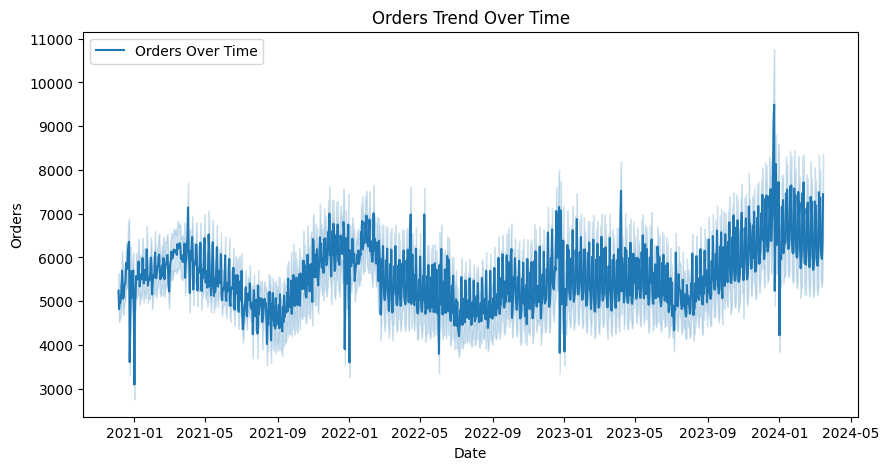

In [7]:
# 📦 Import libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns



# 📅 Parse date columns
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
train_calendar['date'] = pd.to_datetime(train_calendar['date'])
test_calendar['date'] = pd.to_datetime(test_calendar['date'])

# 🔗 Merge calendar info into train/test (ONLY by date)
train = train.merge(train_calendar, on='date', how='left', suffixes=('', '_cal'))
test = test.merge(test_calendar, on='date', how='left', suffixes=('', '_cal'))

# ❌ Drop unavailable-in-test columns from train
cols_to_drop = ['shutdown', 'mini_shutdown', 'blackout', 'mov_change', 'frankfurt_shutdown',
                'precipitation', 'snow', 'user_activity_1', 'user_activity_2']
train = train.drop(columns=[col for col in cols_to_drop if col in train.columns])

# 🧹 Drop text columns that cause issues (holiday_name_cal, holiday_name)
for col in ['holiday_name_cal', 'holiday_name']:
    if col in train.columns:
        train.drop(columns=[col], inplace=True)
    if col in test.columns:
        test.drop(columns=[col], inplace=True)

# ⚙️ Feature Engineering (time features)
for df in [train, test]:
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['month'] = df['date'].dt.month

# ➕ One-hot encode warehouse columns IF they exist (SAFE method)
def safe_one_hot(df, col):
    if col in df.columns:
        df[col] = df[col].astype(str)
        df = pd.get_dummies(df, columns=[col], prefix=col)
    return df

train = safe_one_hot(train, 'warehouse')
train = safe_one_hot(train, 'warehouse_cal')

test = safe_one_hot(test, 'warehouse')
test = safe_one_hot(test, 'warehouse_cal')

# Align columns between train and test (ensure same features)
X = train.drop(columns=['date', 'orders', 'id'])
y = train['orders']
X, test_X = X.align(test.drop(columns=['date', 'id']), join='left', axis=1, fill_value=0)

# ✂️ Split train/validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 🚀 Train LightGBM model
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# 📈 Validate model
val_preds = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, val_preds)
print(f'✅ Validation MAPE: {mape:.4f}')

# 🧩 Predict on test set
test_preds = model.predict(test_X)
test['orders'] = test_preds

# 📝 Prepare submission file
submission = test[['id']].copy()
submission['orders'] = test['orders'].round().astype(int)
submission.to_csv('submission.csv', index=False)

print("🎉 Submission file 'submission.csv' is ready!")

# 📊 Optional EDA Plot (Example)
plt.figure(figsize=(10, 5))
sns.lineplot(x=train['date'], y=train['orders'], label='Orders Over Time')
plt.title('Orders Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

